In [148]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib notebook

In [149]:
params = [[1 , 0.36992, 2459701.601667],
[2 , 0.87688, 2459713.304480],
[3 , 0.06016, 2459717.535348],
[4 , 0.17968, 2459720.294375],
[5 , 0.31926, 2459723.516505],
[6 , 0.36266, 2459724.518253],
[7 , 0.69805, 2459732.260533],
[8 , 0.92396, 2459737.475649],
[9 , 0.96788, 2459738.489422],
[10,  0.47952, 2459773.384653],
[11,  0.52299, 2459774.387998],
[12,  0.60879, 2459776.368797],
[13,  0.65294, 2459777.387836],
[14,  0.69618, 2459778.386007],# (bez części czerwonej)
[15,  0.25688, 2459791.329491],
[16,  0.30010, 2459792.327142],
[17,  0.64627, 2459800.318183],# (słabe)
[18,  0.68972, 2459801.321227],
[19,  0.77652, 2459803.325035],
[20,  0.99137, 2459808.284769],# (słabe)
[21,  0.20818, 2459813.289561],# (słabe)
[22,  0.25057, 2459814.268206],
[23,  0.29497, 2459815.293044],
[24,  0.33831, 2459816.293507]]# (słabe)
params = {x[0]: x[1:] for x in params}
params[1]

[0.36992, 2459701.601667]

In [150]:
df.isna().any(axis=1)

0        False
1        False
2        False
3        False
4        False
         ...  
13016    False
13017    False
13018    False
13019    False
13020    False
Length: 12913, dtype: bool

In [151]:
fns = sorted(glob.glob("*.ave"))
data = {}
for fn in fns:
    k = int(fn[2:4])
    if k not in data: 
        data[k] = {}
    df = pd.read_csv(fn,header=None,delim_whitespace=True)
    mask = ~df.isna().any(axis=1)
    df = df[mask]
    if "red" in fn:
        data[k]["wr"] = df.values[:,0]
        data[k]["wlr"] = np.log10(data[k]["wr"])
        data[k]["fr"] = df.values[:,1]
    else:
        data[k]["wb"] = df.values[:,0]
        data[k]["wlb"] = np.log10(data[k]["wb"])
        data[k]["fb"] = df.values[:,1]
    data[k]["phase"] = params[k][0]
    data[k]["jd"] = params[k][1]

<IPython.core.display.Javascript object>


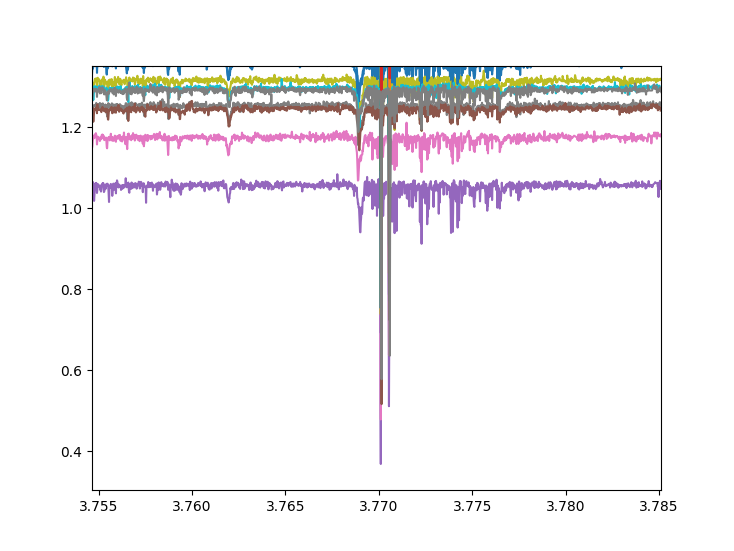

In [152]:
fig, ax = plt.subplots()
for k in data:
    spec = data[k]
    phase = spec["phase"]
    jd = spec["jd"]
    if "wr" in spec:
        ax.plot(spec["wlr"],spec["fr"]+phase)
    if "wb" in spec:
        ax.plot(spec["wlb"],spec["fb"]+phase)


### Fit model

In [153]:
import jax
from jax import lax, random, numpy as jnp
import flax
# from flax.core import freeze, unfreeze
from flax import linen as nn

from flax.training import train_state, checkpoints  # Useful dataclass to keep train state
# import numpy as np                                # Ordinary NumPy
import optax                                        # Optimizers

In [154]:
print(jax.devices())

[GpuDevice(id=0, process_index=0)]


In [480]:
def frequency_encoding(x, min_period, max_period, dimension):
    periods = jnp.logspace(jnp.log10(min_period), jnp.log10(max_period), num=dimension)
    
    y = jnp.sin(2*jnp.pi/periods*x)
    return y

class MLP_single_wavelength_sine(nn.Module):
    architecture: tuple = (256, 256, 256, 256)
    @nn.compact
    def __call__(self, x):
        w = x
        enc_w = frequency_encoding(w, min_period=1e-5, max_period=1.0, dimension=128)
        _x = enc_w
        for features in self.architecture:
            _x = nn.relu(nn.Dense(features)(_x))
        x = nn.Dense(1, bias_init=nn.initializers.ones)(_x)
        return x
    
class MLP_wavelength_sine(nn.Module):
    
    @nn.compact
    def __call__(self, inputs, train):
        log_waves = inputs
        
        DecManyWave = nn.vmap(
                    MLP_single_wavelength_sine, 
                    in_axes=0, out_axes=0,
                    variable_axes={'params': None}, 
                    split_rngs={'params': False})
        
        x = DecManyWave(name="decoder")(log_waves)
        x = x[...,0]
        return x

In [481]:
from jax._src import dtypes

def uniform_custom(min_value, max_value, dtype = jnp.float_):
    def init(key,shape,dtype = dtype):
        dtype = dtypes.canonicalize_dtype(dtype)
        return random.uniform(key, shape, dtype)*(max_value-min_value) + min_value
    return init

class MLP_single_wavelength_sirens(nn.Module):
    architecture: tuple = (256, 256, 256)

    @nn.compact
    def __call__(self, x):
        _x = jnp.array([x])
        features = self.architecture[0]
        _x = jnp.sin(nn.Dense(features,
                              kernel_init=uniform_custom(-30*jnp.sqrt(6/features),30*jnp.sqrt(6/features)),
                              bias_init=uniform_custom(-jnp.pi,jnp.pi))(_x))
        for features in self.architecture[1:]:
            _x = jnp.sin(nn.Dense(features,
                                  kernel_init=uniform_custom(-jnp.sqrt(6/features),jnp.sqrt(6/features)),
                                  bias_init=uniform_custom(-jnp.pi,jnp.pi))(_x))
        x = nn.Dense(1)(_x)
        return x
    
class MLP_wavelength_sirens(nn.Module):
    
    @nn.compact
    def __call__(self, inputs, train):
        log_waves = inputs
        DecManyWave = nn.vmap(
                    MLP_single_wavelength_sirens, 
                    in_axes=0, out_axes=0,
                    variable_axes={'params': None}, 
                    split_rngs={'params': False})
        
        x = DecManyWave(name="decoder")(log_waves)
        x = x[...,0]
        return x
    
# class MLP_wavelength_sirens_batched(nn.Module):
#     @nn.compact
#     def __call__(self, xs, train):
#         Batched_model = nn.vmap(MLP_wavelength_sirens,
#                             in_axes=(0, None),
#                             out_axes=0,
#                             variable_axes={'params': None},
#                             split_rngs={'params': False})
#         return Batched_model(name=None)(xs, train)

### train

In [498]:
TRAINING_STEPS    = 10000000
WARM_UP_STEPS     = 100000
LEARNING_RATE     = 1e-3
NO_SAMPLES        = int(2**16)#37549#int(2**15)
CHECKPOINTS_DIR   = 'ckpts'
# MODEL_NAME        = "MLP_fixed"

In [499]:
def mse_loss(y_pred, y_true):
    return jnp.mean((y_pred - y_true) ** 2)

def mae_loss(y_pred, y_true):
    return jnp.mean(jnp.abs(y_pred - y_true))

def quantile_absolute_error(y_pred, y_true, q=0.95):
    return jnp.quantile(jnp.abs(y_pred - y_true), q=q)

def maximum_absolute_error(y_pred, y_true):
    return jnp.max(jnp.abs(y_pred - y_true))

def mare_loss(y_pred, y_true):
    return jnp.mean(jnp.abs((y_pred - y_true)/y_true))

# average of worst q*100 percent fluxes
def quantile_mean_absolute_error(y_pred, y_true, q=0.95):
    abs_error = jnp.abs(y_pred - y_true)
    v = jnp.quantile(abs_error, q=q)
    return jnp.mean(abs_error, where=(abs_error>v))

In [500]:
def compute_metrics(*, y_pred, y_true):
    loss = mse_loss(y_pred, y_true)
    mae = mae_loss(y_pred, y_true)
    qae090 = quantile_absolute_error(y_pred, y_true, q=0.95)
    max_ae = maximum_absolute_error(y_pred, y_true)
    mare = mare_loss(y_pred, y_true)
    m95_per = quantile_mean_absolute_error(y_pred, y_true, q=0.95)
    metrics = {
      'loss': loss,
      'mae': mae,
      '95_per': qae090,
      'max_ae': max_ae,
      'mare': mare,
      'm95_per': m95_per,
    }
    return metrics

def create_train_state(rng, model):
    """Creates initial `TrainState`."""
    m = model()
    dummpy_input = jnp.ones(NO_SAMPLES)
    params = m.init(rng, dummpy_input, False)['params']
    
    schedule = optax.warmup_cosine_decay_schedule(
        init_value=0.0,
        peak_value=LEARNING_RATE,
        warmup_steps=WARM_UP_STEPS,
        decay_steps=TRAINING_STEPS-WARM_UP_STEPS,
        end_value=0.0,
    )
    tx = optax.adam(learning_rate=schedule)

    return train_state.TrainState.create(apply_fn=m.apply, params=params, tx=tx)


@jax.jit
def train_step(state, batch, rngs):
    """Train for a single step."""
    # Make sure to get a new RNG at every step.
    step = state.step
    rngs = {name: jax.random.fold_in(rng, step) for name, rng in rngs.items()}
    
    def loss_fn(params):
        y_pred = state.apply_fn({'params': params}, 
                                   batch["input"],
                                   train = True,
                                   rngs=rngs)
        loss = mse_loss(y_pred=y_pred, y_true=batch["normed_flux"])
        return loss, y_pred
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_,y_pred), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)

    metrics = compute_metrics(y_pred=y_pred, y_true=batch['normed_flux'])
    
    return state, metrics

@jax.jit
def eval_step(state, batch):
    y_pred = state.apply_fn({'params': state.params},
                        batch["input"], 
                        train=False
                        )
    metrics = compute_metrics(y_pred=y_pred, y_true=batch['normed_flux'])
    return metrics

<IPython.core.display.Javascript object>


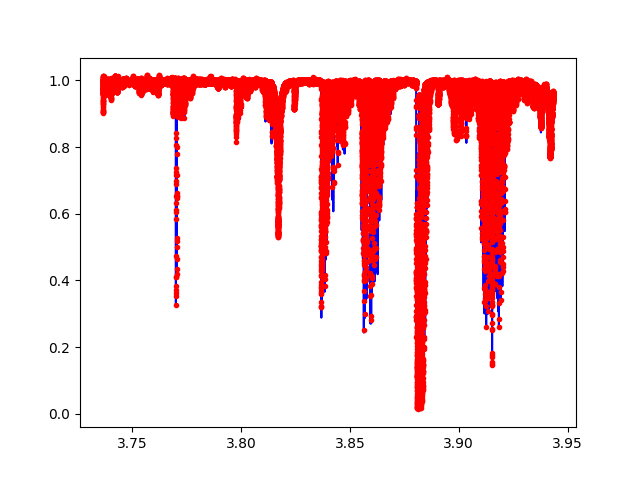

In [501]:
def sample_from_example(wave: np.array, flux: np.array, no_samples:int):
    min_wave = wave[0]
    max_wave = wave[-1]
    
    sampled_wave = np.random.uniform(min_wave, max_wave, size=no_samples)
    
    return sampled_wave, np.interp(sampled_wave, wave, flux)

idx = 1
log_wave = data[idx]["wlr"]
flux = data[idx]["fr"]
sw, sf = sample_from_example(wave=log_wave,
                         flux=flux, 
                         no_samples=NO_SAMPLES
                        )

plt.figure()
plt.plot(log_wave, flux,'b')
plt.plot(sw, sf,'r.')

In [502]:
def get_batch(rng, example):
    while True:
        log_wave = example["wlr"]
        flux = example["fr"]
        sw, sf = sample_from_example(wave=log_wave,
                                 flux=flux, 
                                 no_samples=NO_FLUX_POINTS
                                )
        
        yield {"input":sw,"normed_flux":sf}

In [503]:
def train(state, 
          rngs, 
          train_ds,
          model_name = "MLP_sine",
          training_set_size=10000, 
          no_steps_stats = 100):
    
    full_training_metrics = []
#     full_validation_metrics = []
    train_metrics = []

    for step_number, batch in enumerate(get_batch(rng,train_ds)):

        # Training step:
        state, metrics = train_step(state, batch, rngs)
        train_metrics.append(metrics)

        if state.step % no_steps_stats == 1: # Summarize after each no_steps_stats steps

            # compute mean of metrics across last no_steps_stats steps
            train_summary = jax.device_get(train_metrics)
            train_metrics = []
            train_summary = {
                      k: np.mean([metrics[k] for metrics in train_summary])
                      for k in train_summary[0]}

            # compute metrics on validation dataset
#             if sampling == "full":
#                 val_summary = eval_fixed_MLP(state, 
#                                              val_ds,
#                                              BATCH_SIZE)
#             elif sampling =="nerf":
#                 val_summary = eval_nerf_MLP(state, 
#                                              val_ds,
#                                              BATCH_SIZE)      
#             else:
#                 print("ERROR: sampling must equal 'nerf'/'full'!")
#                 break

            # Gather metrics
            full_training_metrics.append(train_summary)
#             full_validation_metrics.append(val_summary)

            print(f'TRAINING   step: {step_number:6d}, ' + ", ".join([f"{k} = {v:.6f}" for k,v in train_summary.items()]))
#             print(f'VALIDATION step: {step_number:6d}, ' + ", ".join([f"{k} = {v:.6f}" for k,v in val_summary.items()]))

        if state.step > TRAINING_STEPS:
            print("FINISH TRAINING: state.step >= TRAINING_STEPS")
            prefix = f"checkpoint_{model_name}_"
            checkpoints.save_checkpoint(ckpt_dir=CHECKPOINTS_DIR, 
                                        target=state,
                                        overwrite=True,
                                        prefix=prefix,
                                        step=step_number)

#             # Save summary statistics to file:
#             metrics_train_fn = os.path.join(CHECKPOINTS_DIR,f"metrics_train_{model_name}.csv")
#             metrics_val_fn = os.path.join(CHECKPOINTS_DIR,f"metrics_val_{model_name}.csv")

            df_train_summary = pd.DataFrame(full_training_metrics)
#             df_train_summary.to_csv(metrics_train_fn)

#             df_val_summary = pd.DataFrame(full_validation_metrics)
#             df_val_summary.to_csv(metrics_val_fn)       

            break
    return state, df_train_summary

In [504]:
model = MLP_wavelength_sine
model_name = "MLP_sine"
# model = MLP_wavelength_sirens
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
rngs = {'params': jax.random.PRNGKey(0), 'dropout': jax.random.PRNGKey(1)}

state = create_train_state(init_rng, model)
del init_rng

# run training
train_ds = data[1]
state, df_train_summary = train(state, 
                                 rngs, 
                                 train_ds,
                                 model_name = model_name,
                                 training_set_size = TRAINING_SET_SIZE,
                                 no_steps_stats = 10000)

TRAINING   step:      0, 95_per = 0.107222, loss = 0.011497, m95_per = nan, mae = 0.107222, mare = 0.107582, max_ae = 0.107222
TRAINING   step:  10000, 95_per = 0.059333, loss = 0.009012, m95_per = nan, mae = 0.059333, mare = 0.095183, max_ae = 0.059333
TRAINING   step:  20000, 95_per = 0.036654, loss = 0.005181, m95_per = nan, mae = 0.036654, mare = 0.067258, max_ae = 0.036654
TRAINING   step:  30000, 95_per = 0.030588, loss = 0.004779, m95_per = nan, mae = 0.030588, mare = 0.060749, max_ae = 0.030588
TRAINING   step:  40000, 95_per = 0.030637, loss = 0.004872, m95_per = nan, mae = 0.030637, mare = 0.058433, max_ae = 0.030637
TRAINING   step:  50000, 95_per = 0.028941, loss = 0.004012, m95_per = nan, mae = 0.028941, mare = 0.049934, max_ae = 0.028941
TRAINING   step:  60000, 95_per = 0.030148, loss = 0.004358, m95_per = nan, mae = 0.030148, mare = 0.058495, max_ae = 0.030148
TRAINING   step:  70000, 95_per = 0.030700, loss = 0.004029, m95_per = nan, mae = 0.030700, mare = 0.053659, ma

TRAINING   step: 650000, 95_per = 0.019247, loss = 0.002789, m95_per = nan, mae = 0.019247, mare = 0.046771, max_ae = 0.019247
TRAINING   step: 660000, 95_per = 0.018155, loss = 0.001683, m95_per = nan, mae = 0.018155, mare = 0.036109, max_ae = 0.018155
TRAINING   step: 670000, 95_per = 0.018130, loss = 0.001993, m95_per = nan, mae = 0.018130, mare = 0.036899, max_ae = 0.018130
TRAINING   step: 680000, 95_per = 0.018194, loss = 0.001983, m95_per = nan, mae = 0.018194, mare = 0.048568, max_ae = 0.018194
TRAINING   step: 690000, 95_per = 0.017542, loss = 0.001627, m95_per = nan, mae = 0.017542, mare = 0.037238, max_ae = 0.017542
TRAINING   step: 700000, 95_per = 0.017409, loss = 0.001625, m95_per = nan, mae = 0.017409, mare = 0.041570, max_ae = 0.017409
TRAINING   step: 710000, 95_per = 0.017753, loss = 0.001612, m95_per = nan, mae = 0.017753, mare = 0.036502, max_ae = 0.017753
TRAINING   step: 720000, 95_per = 0.018428, loss = 0.002287, m95_per = nan, mae = 0.018428, mare = 0.045177, ma

TRAINING   step: 1300000, 95_per = 0.013617, loss = 0.000631, m95_per = nan, mae = 0.013617, mare = 0.023626, max_ae = 0.013617
TRAINING   step: 1310000, 95_per = 0.013447, loss = 0.001526, m95_per = nan, mae = 0.013447, mare = 0.023624, max_ae = 0.013447
TRAINING   step: 1320000, 95_per = 0.013473, loss = 0.000704, m95_per = nan, mae = 0.013473, mare = 0.025739, max_ae = 0.013473
TRAINING   step: 1330000, 95_per = 0.012892, loss = 0.000622, m95_per = nan, mae = 0.012892, mare = 0.021741, max_ae = 0.012892
TRAINING   step: 1340000, 95_per = 0.012509, loss = 0.000619, m95_per = nan, mae = 0.012509, mare = 0.019144, max_ae = 0.012509
TRAINING   step: 1350000, 95_per = 0.012818, loss = 0.000608, m95_per = nan, mae = 0.012818, mare = 0.024130, max_ae = 0.012818
TRAINING   step: 1360000, 95_per = 0.013274, loss = 0.000658, m95_per = nan, mae = 0.013274, mare = 0.024432, max_ae = 0.013274
TRAINING   step: 1370000, 95_per = 0.012764, loss = 0.000747, m95_per = nan, mae = 0.012764, mare = 0.02

TRAINING   step: 1950000, 95_per = 0.012054, loss = 0.000498, m95_per = nan, mae = 0.012054, mare = 0.021309, max_ae = 0.012054
TRAINING   step: 1960000, 95_per = 0.011944, loss = 0.000564, m95_per = nan, mae = 0.011944, mare = 0.023311, max_ae = 0.011944
TRAINING   step: 1970000, 95_per = 0.012032, loss = 0.000471, m95_per = nan, mae = 0.012032, mare = 0.021795, max_ae = 0.012032
TRAINING   step: 1980000, 95_per = 0.012125, loss = 0.000471, m95_per = nan, mae = 0.012125, mare = 0.021678, max_ae = 0.012125
TRAINING   step: 1990000, 95_per = 0.011686, loss = 0.000459, m95_per = nan, mae = 0.011686, mare = 0.022194, max_ae = 0.011686
TRAINING   step: 2000000, 95_per = 0.011422, loss = 0.000453, m95_per = nan, mae = 0.011422, mare = 0.017643, max_ae = 0.011422
TRAINING   step: 2010000, 95_per = 0.011501, loss = 0.000438, m95_per = nan, mae = 0.011501, mare = 0.022328, max_ae = 0.011501
TRAINING   step: 2020000, 95_per = 0.011925, loss = 0.000469, m95_per = nan, mae = 0.011925, mare = 0.02

TRAINING   step: 2600000, 95_per = 0.010541, loss = 0.000395, m95_per = nan, mae = 0.010541, mare = 0.023224, max_ae = 0.010541
TRAINING   step: 2610000, 95_per = 0.010807, loss = 0.000392, m95_per = nan, mae = 0.010807, mare = 0.021964, max_ae = 0.010807
TRAINING   step: 2620000, 95_per = 0.011053, loss = 0.000440, m95_per = nan, mae = 0.011053, mare = 0.018674, max_ae = 0.011053
TRAINING   step: 2630000, 95_per = 0.011229, loss = 0.000409, m95_per = nan, mae = 0.011229, mare = 0.020799, max_ae = 0.011229
TRAINING   step: 2640000, 95_per = 0.011028, loss = 0.000401, m95_per = nan, mae = 0.011028, mare = 0.020327, max_ae = 0.011028
TRAINING   step: 2650000, 95_per = 0.010958, loss = 0.000365, m95_per = nan, mae = 0.010958, mare = 0.022476, max_ae = 0.010958
TRAINING   step: 2660000, 95_per = 0.010543, loss = 0.000385, m95_per = nan, mae = 0.010543, mare = 0.022079, max_ae = 0.010543
TRAINING   step: 2670000, 95_per = 0.010294, loss = 0.000309, m95_per = nan, mae = 0.010294, mare = 0.01

TRAINING   step: 3250000, 95_per = 0.010317, loss = 0.000310, m95_per = nan, mae = 0.010317, mare = 0.017487, max_ae = 0.010317
TRAINING   step: 3260000, 95_per = 0.010365, loss = 0.000310, m95_per = nan, mae = 0.010365, mare = 0.018651, max_ae = 0.010365
TRAINING   step: 3270000, 95_per = 0.010043, loss = 0.000286, m95_per = nan, mae = 0.010043, mare = 0.017042, max_ae = 0.010043
TRAINING   step: 3280000, 95_per = 0.010093, loss = 0.000290, m95_per = nan, mae = 0.010093, mare = 0.018786, max_ae = 0.010093
TRAINING   step: 3290000, 95_per = 0.010071, loss = 0.000276, m95_per = nan, mae = 0.010071, mare = 0.020089, max_ae = 0.010071
TRAINING   step: 3300000, 95_per = 0.009888, loss = 0.000261, m95_per = nan, mae = 0.009888, mare = 0.017338, max_ae = 0.009888
TRAINING   step: 3310000, 95_per = 0.010147, loss = 0.000279, m95_per = nan, mae = 0.010147, mare = 0.017149, max_ae = 0.010147
TRAINING   step: 3320000, 95_per = 0.010135, loss = 0.000328, m95_per = nan, mae = 0.010135, mare = 0.01

TRAINING   step: 3900000, 95_per = 0.009035, loss = 0.000213, m95_per = nan, mae = 0.009035, mare = 0.014414, max_ae = 0.009035
TRAINING   step: 3910000, 95_per = 0.009250, loss = 0.000218, m95_per = nan, mae = 0.009250, mare = 0.015342, max_ae = 0.009250
TRAINING   step: 3920000, 95_per = 0.009276, loss = 0.000217, m95_per = nan, mae = 0.009276, mare = 0.013502, max_ae = 0.009276
TRAINING   step: 3930000, 95_per = 0.009211, loss = 0.000210, m95_per = nan, mae = 0.009211, mare = 0.013353, max_ae = 0.009211
TRAINING   step: 3940000, 95_per = 0.009432, loss = 0.000246, m95_per = nan, mae = 0.009432, mare = 0.014184, max_ae = 0.009432
TRAINING   step: 3950000, 95_per = 0.009020, loss = 0.000204, m95_per = nan, mae = 0.009020, mare = 0.013723, max_ae = 0.009020
TRAINING   step: 3960000, 95_per = 0.009226, loss = 0.000232, m95_per = nan, mae = 0.009226, mare = 0.015711, max_ae = 0.009226
TRAINING   step: 3970000, 95_per = 0.008993, loss = 0.000205, m95_per = nan, mae = 0.008993, mare = 0.01

TRAINING   step: 4550000, 95_per = 0.007783, loss = 0.000148, m95_per = nan, mae = 0.007783, mare = 0.011300, max_ae = 0.007783
TRAINING   step: 4560000, 95_per = 0.007783, loss = 0.000171, m95_per = nan, mae = 0.007783, mare = 0.012583, max_ae = 0.007783
TRAINING   step: 4570000, 95_per = 0.007592, loss = 0.000160, m95_per = nan, mae = 0.007592, mare = 0.011925, max_ae = 0.007592
TRAINING   step: 4580000, 95_per = 0.007678, loss = 0.000142, m95_per = nan, mae = 0.007678, mare = 0.011340, max_ae = 0.007678
TRAINING   step: 4590000, 95_per = 0.007770, loss = 0.000175, m95_per = nan, mae = 0.007770, mare = 0.013452, max_ae = 0.007770
TRAINING   step: 4600000, 95_per = 0.007840, loss = 0.000160, m95_per = nan, mae = 0.007840, mare = 0.012155, max_ae = 0.007840
TRAINING   step: 4610000, 95_per = 0.007620, loss = 0.000142, m95_per = nan, mae = 0.007620, mare = 0.012007, max_ae = 0.007620
TRAINING   step: 4620000, 95_per = 0.007720, loss = 0.000155, m95_per = nan, mae = 0.007720, mare = 0.01

TRAINING   step: 5200000, 95_per = 0.006625, loss = 0.000197, m95_per = nan, mae = 0.006625, mare = 0.012075, max_ae = 0.006625
TRAINING   step: 5210000, 95_per = 0.006460, loss = 0.000129, m95_per = nan, mae = 0.006460, mare = 0.009856, max_ae = 0.006460
TRAINING   step: 5220000, 95_per = 0.006141, loss = 0.000106, m95_per = nan, mae = 0.006141, mare = 0.009536, max_ae = 0.006141
TRAINING   step: 5230000, 95_per = 0.006307, loss = 0.000140, m95_per = nan, mae = 0.006307, mare = 0.013066, max_ae = 0.006307
TRAINING   step: 5240000, 95_per = 0.006332, loss = 0.000105, m95_per = nan, mae = 0.006332, mare = 0.011321, max_ae = 0.006332
TRAINING   step: 5250000, 95_per = 0.006082, loss = 0.000100, m95_per = nan, mae = 0.006082, mare = 0.009989, max_ae = 0.006082
TRAINING   step: 5260000, 95_per = 0.006335, loss = 0.000107, m95_per = nan, mae = 0.006335, mare = 0.011337, max_ae = 0.006335
TRAINING   step: 5270000, 95_per = 0.006216, loss = 0.000107, m95_per = nan, mae = 0.006216, mare = 0.01

TRAINING   step: 5850000, 95_per = 0.005380, loss = 0.000070, m95_per = nan, mae = 0.005380, mare = 0.008285, max_ae = 0.005380
TRAINING   step: 5860000, 95_per = 0.005271, loss = 0.000074, m95_per = nan, mae = 0.005271, mare = 0.009379, max_ae = 0.005271
TRAINING   step: 5870000, 95_per = 0.005336, loss = 0.000069, m95_per = nan, mae = 0.005336, mare = 0.007801, max_ae = 0.005336
TRAINING   step: 5880000, 95_per = 0.005203, loss = 0.000066, m95_per = nan, mae = 0.005203, mare = 0.008415, max_ae = 0.005203
TRAINING   step: 5890000, 95_per = 0.005271, loss = 0.000073, m95_per = nan, mae = 0.005271, mare = 0.010009, max_ae = 0.005271
TRAINING   step: 5900000, 95_per = 0.005186, loss = 0.000065, m95_per = nan, mae = 0.005186, mare = 0.007757, max_ae = 0.005186
TRAINING   step: 5910000, 95_per = 0.005284, loss = 0.000070, m95_per = nan, mae = 0.005284, mare = 0.010000, max_ae = 0.005284
TRAINING   step: 5920000, 95_per = 0.005107, loss = 0.000071, m95_per = nan, mae = 0.005107, mare = 0.00

TRAINING   step: 6500000, 95_per = 0.004241, loss = 0.000046, m95_per = nan, mae = 0.004241, mare = 0.007082, max_ae = 0.004241
TRAINING   step: 6510000, 95_per = 0.004205, loss = 0.000045, m95_per = nan, mae = 0.004205, mare = 0.006867, max_ae = 0.004205
TRAINING   step: 6520000, 95_per = 0.004283, loss = 0.000062, m95_per = nan, mae = 0.004283, mare = 0.007273, max_ae = 0.004283
TRAINING   step: 6530000, 95_per = 0.004257, loss = 0.000067, m95_per = nan, mae = 0.004257, mare = 0.007369, max_ae = 0.004257
TRAINING   step: 6540000, 95_per = 0.004029, loss = 0.000041, m95_per = nan, mae = 0.004029, mare = 0.006507, max_ae = 0.004029
TRAINING   step: 6550000, 95_per = 0.004181, loss = 0.000044, m95_per = nan, mae = 0.004181, mare = 0.006557, max_ae = 0.004181
TRAINING   step: 6560000, 95_per = 0.004151, loss = 0.000043, m95_per = nan, mae = 0.004151, mare = 0.007005, max_ae = 0.004151
TRAINING   step: 6570000, 95_per = 0.004220, loss = 0.000044, m95_per = nan, mae = 0.004220, mare = 0.00

TRAINING   step: 7150000, 95_per = 0.003268, loss = 0.000025, m95_per = nan, mae = 0.003268, mare = 0.005251, max_ae = 0.003268
TRAINING   step: 7160000, 95_per = 0.003321, loss = 0.000028, m95_per = nan, mae = 0.003321, mare = 0.005032, max_ae = 0.003321
TRAINING   step: 7170000, 95_per = 0.003211, loss = 0.000026, m95_per = nan, mae = 0.003211, mare = 0.005356, max_ae = 0.003211
TRAINING   step: 7180000, 95_per = 0.003159, loss = 0.000022, m95_per = nan, mae = 0.003159, mare = 0.004411, max_ae = 0.003159
TRAINING   step: 7190000, 95_per = 0.003257, loss = 0.000028, m95_per = nan, mae = 0.003257, mare = 0.005626, max_ae = 0.003257
TRAINING   step: 7200000, 95_per = 0.003183, loss = 0.000025, m95_per = nan, mae = 0.003183, mare = 0.005518, max_ae = 0.003183
TRAINING   step: 7210000, 95_per = 0.003274, loss = 0.000026, m95_per = nan, mae = 0.003274, mare = 0.005451, max_ae = 0.003274
TRAINING   step: 7220000, 95_per = 0.003178, loss = 0.000026, m95_per = nan, mae = 0.003178, mare = 0.00

TRAINING   step: 7800000, 95_per = 0.002491, loss = 0.000014, m95_per = nan, mae = 0.002491, mare = 0.003840, max_ae = 0.002491
TRAINING   step: 7810000, 95_per = 0.002530, loss = 0.000015, m95_per = nan, mae = 0.002530, mare = 0.004098, max_ae = 0.002530
TRAINING   step: 7820000, 95_per = 0.002485, loss = 0.000014, m95_per = nan, mae = 0.002485, mare = 0.003963, max_ae = 0.002485
TRAINING   step: 7830000, 95_per = 0.002423, loss = 0.000013, m95_per = nan, mae = 0.002423, mare = 0.003706, max_ae = 0.002423
TRAINING   step: 7840000, 95_per = 0.002501, loss = 0.000014, m95_per = nan, mae = 0.002501, mare = 0.003542, max_ae = 0.002501
TRAINING   step: 7850000, 95_per = 0.002410, loss = 0.000014, m95_per = nan, mae = 0.002410, mare = 0.004014, max_ae = 0.002410
TRAINING   step: 7860000, 95_per = 0.002449, loss = 0.000014, m95_per = nan, mae = 0.002449, mare = 0.003290, max_ae = 0.002449
TRAINING   step: 7870000, 95_per = 0.002385, loss = 0.000012, m95_per = nan, mae = 0.002385, mare = 0.00

TRAINING   step: 8450000, 95_per = 0.001861, loss = 0.000007, m95_per = nan, mae = 0.001861, mare = 0.002506, max_ae = 0.001861
TRAINING   step: 8460000, 95_per = 0.001913, loss = 0.000008, m95_per = nan, mae = 0.001913, mare = 0.002690, max_ae = 0.001913
TRAINING   step: 8470000, 95_per = 0.001853, loss = 0.000007, m95_per = nan, mae = 0.001853, mare = 0.002599, max_ae = 0.001853
TRAINING   step: 8480000, 95_per = 0.001874, loss = 0.000008, m95_per = nan, mae = 0.001874, mare = 0.002862, max_ae = 0.001874
TRAINING   step: 8490000, 95_per = 0.001880, loss = 0.000008, m95_per = nan, mae = 0.001880, mare = 0.002793, max_ae = 0.001880
TRAINING   step: 8500000, 95_per = 0.001873, loss = 0.000007, m95_per = nan, mae = 0.001873, mare = 0.002730, max_ae = 0.001873
TRAINING   step: 8510000, 95_per = 0.001883, loss = 0.000008, m95_per = nan, mae = 0.001883, mare = 0.002831, max_ae = 0.001883
TRAINING   step: 8520000, 95_per = 0.001842, loss = 0.000007, m95_per = nan, mae = 0.001842, mare = 0.00

TRAINING   step: 9100000, 95_per = 0.001534, loss = 0.000005, m95_per = nan, mae = 0.001534, mare = 0.001962, max_ae = 0.001534
TRAINING   step: 9110000, 95_per = 0.001537, loss = 0.000005, m95_per = nan, mae = 0.001537, mare = 0.001989, max_ae = 0.001537
TRAINING   step: 9120000, 95_per = 0.001503, loss = 0.000005, m95_per = nan, mae = 0.001503, mare = 0.002044, max_ae = 0.001503
TRAINING   step: 9130000, 95_per = 0.001529, loss = 0.000005, m95_per = nan, mae = 0.001529, mare = 0.002154, max_ae = 0.001529
TRAINING   step: 9140000, 95_per = 0.001525, loss = 0.000005, m95_per = nan, mae = 0.001525, mare = 0.002224, max_ae = 0.001525
TRAINING   step: 9150000, 95_per = 0.001525, loss = 0.000005, m95_per = nan, mae = 0.001525, mare = 0.002037, max_ae = 0.001525
TRAINING   step: 9160000, 95_per = 0.001512, loss = 0.000005, m95_per = nan, mae = 0.001512, mare = 0.001923, max_ae = 0.001512
TRAINING   step: 9170000, 95_per = 0.001493, loss = 0.000005, m95_per = nan, mae = 0.001493, mare = 0.00

TRAINING   step: 9750000, 95_per = 0.001384, loss = 0.000004, m95_per = nan, mae = 0.001384, mare = 0.001816, max_ae = 0.001384
TRAINING   step: 9760000, 95_per = 0.001366, loss = 0.000004, m95_per = nan, mae = 0.001366, mare = 0.001846, max_ae = 0.001366
TRAINING   step: 9770000, 95_per = 0.001381, loss = 0.000004, m95_per = nan, mae = 0.001381, mare = 0.001886, max_ae = 0.001381
TRAINING   step: 9780000, 95_per = 0.001391, loss = 0.000004, m95_per = nan, mae = 0.001391, mare = 0.001965, max_ae = 0.001391
TRAINING   step: 9790000, 95_per = 0.001374, loss = 0.000004, m95_per = nan, mae = 0.001374, mare = 0.001830, max_ae = 0.001374
TRAINING   step: 9800000, 95_per = 0.001363, loss = 0.000004, m95_per = nan, mae = 0.001363, mare = 0.001731, max_ae = 0.001363
TRAINING   step: 9810000, 95_per = 0.001414, loss = 0.000004, m95_per = nan, mae = 0.001414, mare = 0.001856, max_ae = 0.001414
TRAINING   step: 9820000, 95_per = 0.001358, loss = 0.000004, m95_per = nan, mae = 0.001358, mare = 0.00

<IPython.core.display.Javascript object>


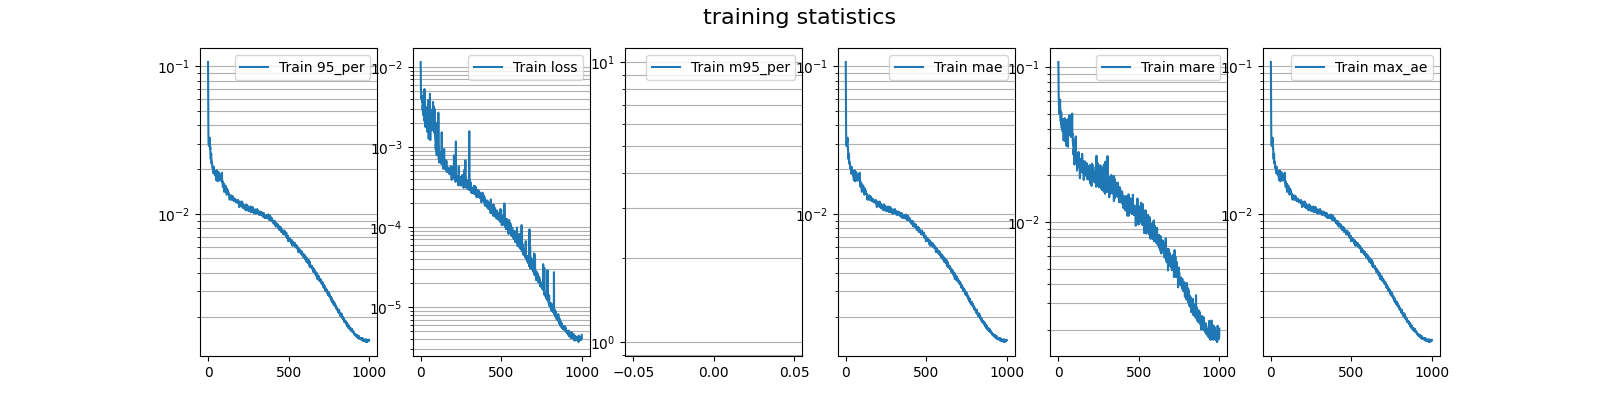

In [506]:
# Plot
ncols= df_train_summary.shape[1]
fig, axs = plt.subplots(ncols=ncols, figsize=(16,4))
fig.suptitle(f"training statistics", fontsize=16)
for i, c in enumerate(df_train_summary.columns):
    axs[i].semilogy(df_train_summary[c],label=f"Train {c}")
    axs[i].legend()
    axs[i].grid(which="both", axis='y')

In [512]:
prefix = f"checkpoint_{model_name}_"
restored_state = checkpoints.restore_checkpoint(ckpt_dir=CHECKPOINTS_DIR, target=state, prefix=prefix)
if state is restored_state:
    raise FileNotFoundError(f"Cannot load checkpoint from {CHECKPOINTS_DIR}")

In [513]:
@jax.jit
def predict(state, batch):
    y_pred = state.apply_fn({'params': state.params}, 
                        batch["input"], 
                        train=False
                       )
    return compute_metrics(y_pred=y_pred, y_true=batch['normed_flux']), y_pred

idx = 1
spec = data[idx]
log_wave = spec["wlr"]
exact_flux = spec["fr"]
batch = {"input":log_wave,"normed_flux":exact_flux}
metrics, predicted_normed_flux = predict(restored_state, batch)
metrics

{'95_per': DeviceArray(0.00723462, dtype=float32),
 'loss': DeviceArray(1.5475436e-05, dtype=float32),
 'm95_per': DeviceArray(0.01351268, dtype=float32),
 'mae': DeviceArray(0.00223602, dtype=float32),
 'mare': DeviceArray(0.0045675, dtype=float32),
 'max_ae': DeviceArray(0.05694015, dtype=float32)}

<IPython.core.display.Javascript object>


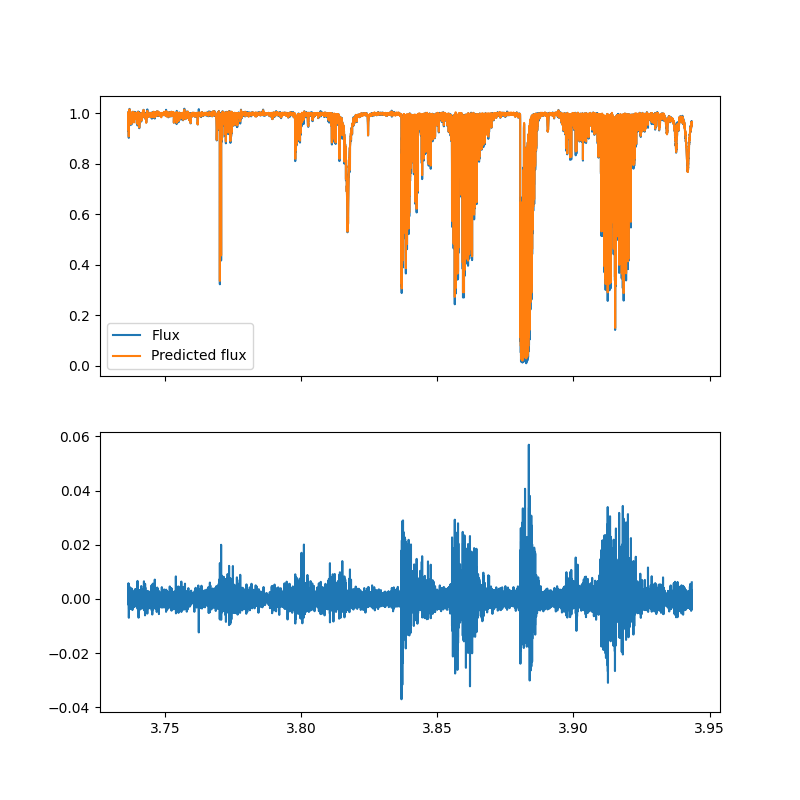

1.5475436157430522e-05, 0.002236019354313612, 0.007234619930386543


In [514]:
fig, axs = plt.subplots(nrows=2,figsize=(8,8),sharex=True)

axs[0].plot(log_wave, exact_flux,label="Flux")
axs[0].plot(log_wave, predicted_normed_flux,label="Predicted flux")
axs[0].legend()

axs[1].plot(log_wave, (predicted_normed_flux-exact_flux))

mse = mse_loss(predicted_normed_flux,exact_flux)
mae = mae_loss(predicted_normed_flux,exact_flux)
per = quantile_absolute_error(predicted_normed_flux,exact_flux,q=0.95)
print(f"{mse}, {mae}, {per}")